# pseudovirus neutralisation test (pVNT)

This notebook used the data of observed reduction of neutralising antibody response in pseudovirus neutralisation assay from Beguir et al. to validate the immune escape score predicted by our model.

## Set up analysis

### Import python modules

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import scipy.stats as ss
from adjustText import adjust_text

### Read in data 

This data can be downloaded from Table S.3. of Beguir et al. 
The preprint is available: https://www.biorxiv.org/content/10.1101/2021.12.24.474095v1.full

In [2]:
pVNT=pd.read_csv('../data/pVNT.csv')

In [3]:
pVNT.head()

,Lineage,WHO,Mutation,Reduction
0,B.1.1.7,Alpha,N501Y,22.92
1,B.1.1.7+E484K,Alpha,E484K;N501Y,74.65
2,B.1.351,Beta,K417N;E484K;N501Y,47.19
3,P.1,Gamma,K417T;E484K;N501Y,47.66
4,B.1.617.2,Delta,K417N;L452R;T478K,49.43


Obtain scores based on the sequences

In [5]:
with open("../data/Covid19_RBD_seq.txt", "r") as f:  
    seq = f.read() 

In [6]:
def get_seq(m_list,sequence):
    for row in m_list:
        _, idx, mt = row[0], int(row[1:-1])-331, row[-1]
        sequence = sequence[:idx] + mt + sequence[(idx + 1) :]
    return(sequence)

In [7]:
pVNT["seq"]=pVNT.apply(
        lambda row : get_seq(row["Mutation"].split(";"),seq),axis=1
        )

In [9]:
## get the score
gisaid_score=pd.read_csv('../data/gisaid_score.csv',index_col=0)
gisaid_score["escape_score"]=gisaid_score.iloc[:,2:10].mean(axis=1)
seq_cache=gisaid_score.set_index('seq')["escape_score"].to_dict()
pVNT["score"]=pVNT.seq.map(seq_cache)

In [10]:
pVNT.head()

,Lineage,WHO,Mutation,Reduction,seq,score
0,B.1.1.7,Alpha,N501Y,22.92,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0.000733
1,B.1.1.7+E484K,Alpha,E484K;N501Y,74.65,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0.454673
2,B.1.351,Beta,K417N;E484K;N501Y,47.19,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0.606424
3,P.1,Gamma,K417T;E484K;N501Y,47.66,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0.566062
4,B.1.617.2,Delta,K417N;L452R;T478K,49.43,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0.200867


## plot

In [12]:
sns.set(rc={'figure.figsize':(5.5,5.5)})
sns.set_theme(style="white")

Text(15.0, 0.5, 'pVNT50 Reduction %')

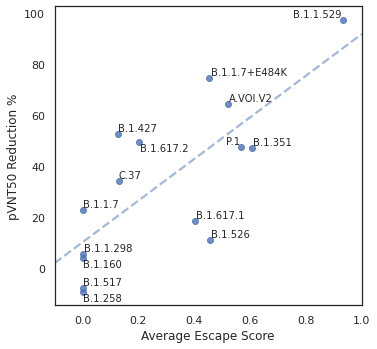

In [13]:
fig, ax = plt.subplots()
ax.set_xlim([-0.1,1])
sns.regplot(x="score",y="Reduction",data=pVNT,ci=None,ax=ax,truncate=False,line_kws={"alpha":0.5,"linestyle":'--'})
texts=[]
for idx,row in pVNT.iterrows():
    x = row["score"]
    y = row["Reduction"]
    text = row["Lineage"]
    texts.append(plt.text(x,y,text,horizontalalignment='right',verticalalignment='bottom',fontsize=10))
adjust_text(texts)
ax.set_xlabel("Average Escape Score")
ax.set_ylabel("pVNT50 Reduction %")
#plt.savefig('figures/pVNT_figure.png',dpi=500)

Spearman Correlation

In [14]:
ss.spearmanr(pVNT.Reduction,pVNT.score)

SpearmanrResult(correlation=0.7178571428571427, pvalue=0.002581165308218854)

Pearson Correlation

In [15]:
ss.pearsonr(pVNT.Reduction,pVNT.score)

(0.7584216899498254, 0.0010481600539293816)